<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-необходимых-для-работы-библиотек" data-toc-modified-id="Импорт-необходимых-для-работы-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт необходимых для работы библиотек</a></span></li><li><span><a href="#Загрузка-данных-из-csv-файла" data-toc-modified-id="Загрузка-данных-из-csv-файла-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных из csv-файла</a></span></li><li><span><a href="#Визуализация-данных" data-toc-modified-id="Визуализация-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Визуализация данных</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Добавление-новых-столбцов-в-таблицу" data-toc-modified-id="Добавление-новых-столбцов-в-таблицу-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Добавление новых столбцов в таблицу</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></li></ul></div>

# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

*Цель исследования:* Установить взаимосвязь параметров объекта на рыночную стоимость объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

*Этапы исследования:*

1. Чтение данных из файла. Общее знакомство с данными
2. Предобработка данных:
 - Определение и заполнение пропусков в данных
 - Изменение типов данных, в соответствии со значениями
 - Определение и исправление аномальных значений в данных
3. Добавление дополнительных данных, на основе оригинальных, для дальнейших вычислений
4. Исследовательский анализ данных:
 - Изучение параметров объектов
 - Изучение скорости продажи объектов
 - Изучение влияния параметров на полную стоимость объектов
 - Определение средней стоимости одного $м^2$ в 10 населенных пунктах с наибольшим числом объявлений
 - Определение изменения стоимости объектов в зависимости от удаленности от центра города

## Подготовка данных

### Импорт необходимых для работы библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix

In [2]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Ограничение десятичных знаков в типах данных float
pd.set_option('display.float_format', '{:.3f}'.format)

# Шаблон оформления графиков
sns.set_palette('deep')
sns.set_style("whitegrid")

### Загрузка данных из csv-файла

In [3]:
# Использую конструкцию try-except для резервирования загрузки данных
try:
    df = pd.read_csv(
        '/datasets/real_estate_data.csv',
        sep='\t',
        parse_dates=['first_day_exposition'])
except:
    df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/real_estate_data.csv',
        sep='\t',
        parse_dates=['first_day_exposition'])

### Визуализация данных

In [4]:
# Вывод и изучение общей информации о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Построим гистограммы числовых столбцов датафрейма**

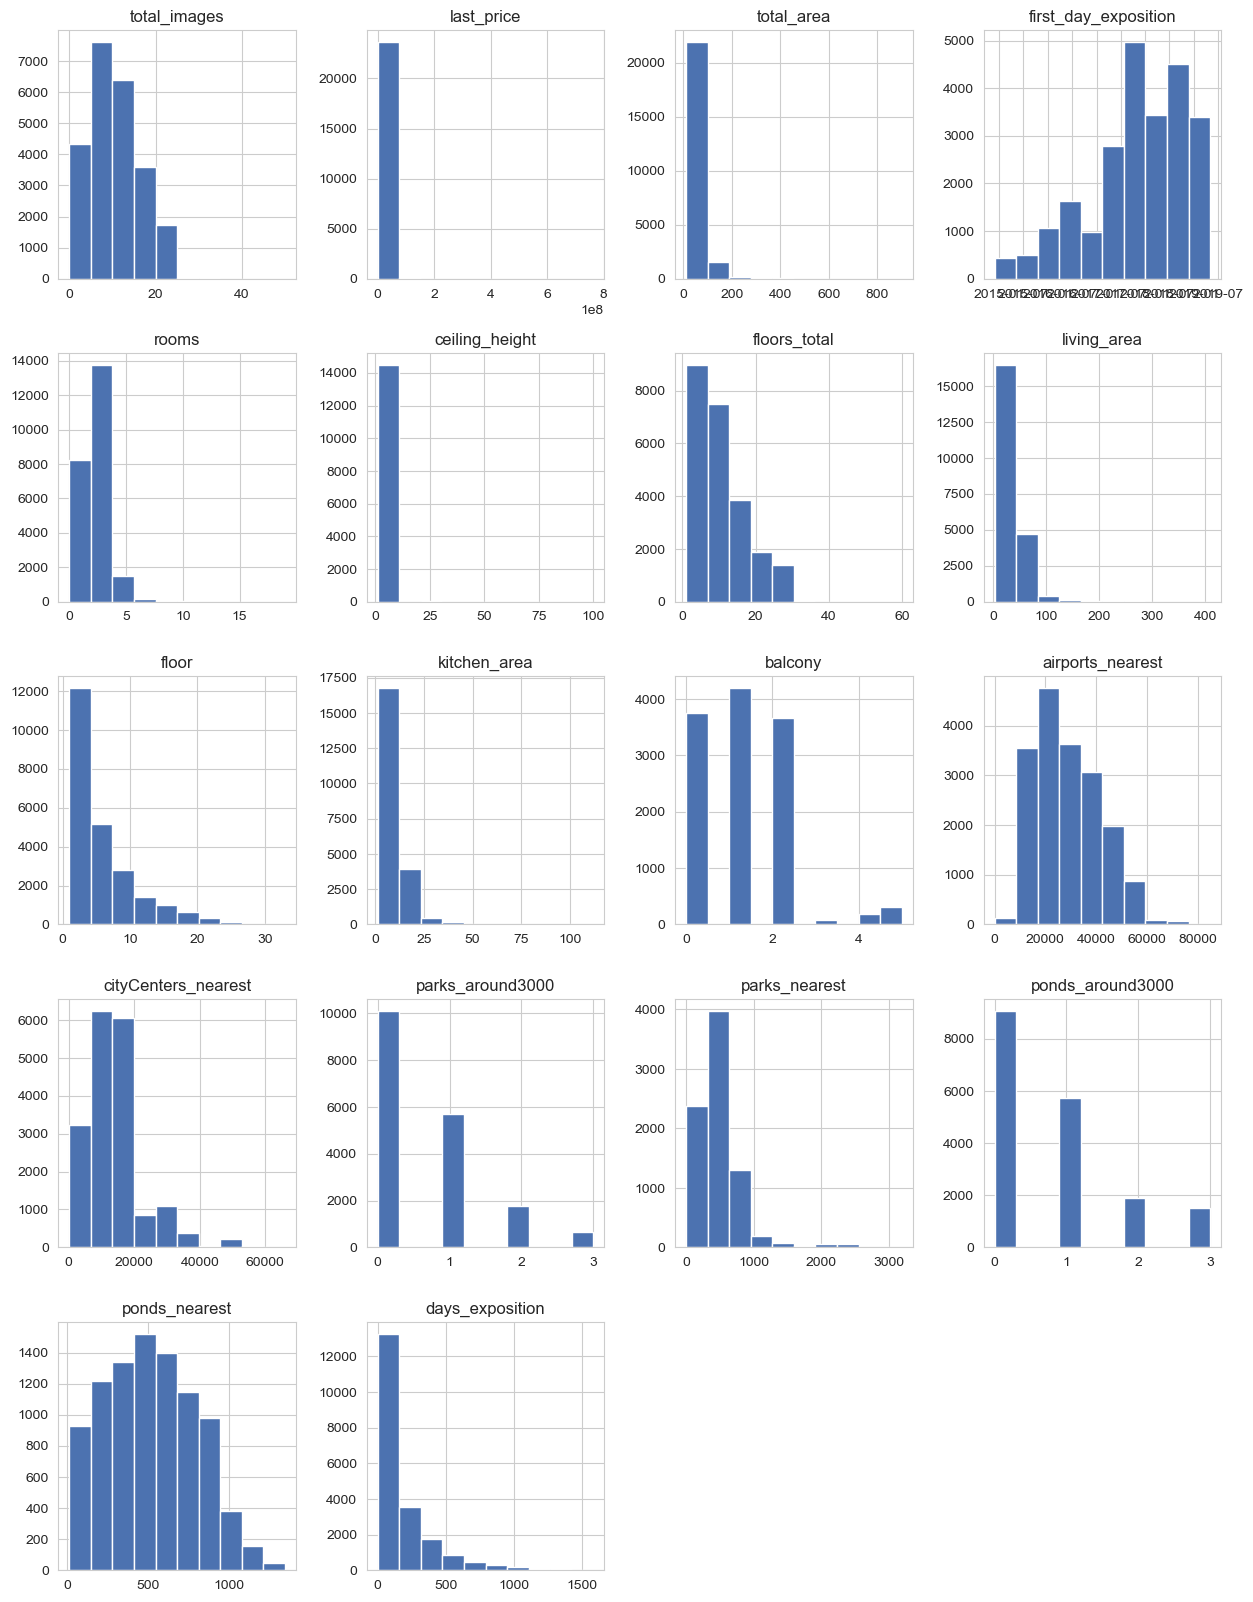

In [5]:
df.hist(figsize=(15, 20))
plt.show();

## Предобработка данных

**Определение имеющихся пропусков данных**

In [6]:
(pd.DataFrame(round(df.isna().mean()*100, 1))
.style.background_gradient('coolwarm'))

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


**Заполним пропуски там, где это возможно**

Данные с пустыми значениями столбца `locality_name` удаляю, ввиду их малочисленности

In [7]:
df = df.dropna(subset=['locality_name'])

Замена нулевых значений в столбцах `balcony`, `parks_around3000` и `ponds_around3000` на нуль, а в `is_apartment` - на False

In [8]:
df['balcony'] = df['balcony'].fillna(0).astype('int')
df['parks_around3000'] = df['parks_around3000'].fillna(0).astype('int')
df['ponds_around3000'] = df['ponds_around3000'].fillna(0).astype('int')
df['is_apartment'] = df['is_apartment'].fillna(False)

Замена нулевых значений в столбце `floors_total` на `floor`, предполагая, что это квартиры на последних этажах

In [9]:
df['floors_total'] = df['floors_total'].fillna(df['floor'])

Учитываю квартиры-студии, у которых площадь кухни совмещена с жилой

In [10]:
df.loc[(df['kitchen_area'] != 0) & (df['studio'] == True), 'kitchen_area'] = 0

Вычисление соотношений жилой площади и площади кухни к общей

In [11]:
share_living_area = (df['living_area'] / df['total_area']).median()
share_kitchen_area = (df['kitchen_area'] / df['total_area']).median()

print(f'Доля жилых помещений в общей площади: {share_living_area:.0%}')
print(f'Доля площади кухни в общей площади: {share_kitchen_area:.0%}')

Доля жилых помещений в общей площади: 57%
Доля площади кухни в общей площади: 17%


**Считаем с применением медианной доли площади жилых помещений и кухни**

In [12]:
df['living_area'] = df['living_area'].fillna(df['total_area'] * share_living_area)
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * share_kitchen_area)

Производим проверку правильности заполнения данных

In [13]:
print(df[df['total_area'] < df['living_area']].shape)
print(df[df['living_area'] < df['kitchen_area']].shape)
print(df[df['total_area'] < df['kitchen_area']].shape)

(0, 22)
(356, 22)
(0, 22)


В датафрейме присутствуют строки, где площадь кухни больше жилой площади. Поменяем местами такие строки, а затем вновь произведем проверку

In [14]:
df['area_tmp'] = df['living_area']
df['living_area'] = df['living_area'].where(df['living_area'] \
                            > df['kitchen_area'], df['kitchen_area'])
df['kitchen_area'] = df['kitchen_area'].where(df['living_area'] \
                            > df['kitchen_area'], df['area_tmp'])

# Снова производим проверку
print(df[df['total_area'] < df['living_area']].shape)
print(df[df['living_area'] < df['kitchen_area']].shape)
print(df[df['total_area'] < df['kitchen_area']].shape)

(0, 23)
(0, 23)
(0, 23)


**Теперь все в порядке**

Рассмотрим уникальные значения столбца `ceiling_height`

In [15]:
df['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Видим, что в значениях высоты потолка присутствуют пропуски, а также аномальные значения

Заменим в столбце `ceiling_height` пропущенные значения медианными и изменим тип данных на float

In [16]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['ceiling_height'] = df['ceiling_height'].astype('float')

Заменим аномально большие значения на верные, умножив их на 0,1

In [17]:
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] = df['ceiling_height'] * 0.1

Проверим правильность замены значений

In [18]:
df['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.03,  1.2 ,  1.4 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,
        2.3 ,  2.34,  2.4 ,  2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,
        2.5 ,  2.51,  2.52,  2.53,  2.54,  2.55,  2.56,  2.57,  2.58,
        2.59,  2.6 ,  2.61,  2.62,  2.63,  2.64,  2.65,  2.66,  2.67,
        2.68,  2.69,  2.7 ,  2.71,  2.72,  2.73,  2.74,  2.75,  2.76,
        2.77,  2.78,  2.79,  2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,
        2.86,  2.87,  2.88,  2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,
        2.95,  2.96,  2.97,  2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,
        3.04,  3.05,  3.06,  3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,
        3.13,  3.14,  3.15,  3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,
        3.23,  3.24,  3.25,  3.26,  3.27,  3.28,  3.29,  3.3 ,  3.31,
        3.32,  3.33,  3.34,  3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,
        3.42,  3.43,  3.44,  3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,
        3.51,  3.52,  3.53,  3.54,  3.55,  3.56,  3.57,  3.58,  3.59,
        3.6 ,  3.62,

**Промежуточный вывод:** По результатам обработки данных можно предположить, что пропусками являются неполные данные об объектах, заполняемые пользователями. Так, очевидно, что пропуски в столбце `balcony` означают отсутствие балконов, которые пользователи не заполняли. В столбце `is_apartment` причина та же: пользователи просто не заполняли это поле, если жилье не относится к апартаментам. Причиной, может стать, также ошибки при сборе и перемещениях данных.

**Заменим типы данных**

Изменим тип данных столбца `first_day_exposition` на datetime и изменим часовой пояс на UTC+3, заменим пропуски в столбце `days_exposition` и изменим тип данных на int

In [19]:
df['days_exposition'] = (
    df['days_exposition']
    .fillna((pd.Timestamp('today') - df['first_day_exposition']).dt.days))

df['first_day_exposition'] = df['first_day_exposition'] + pd.Timedelta(hours=3)
df['first_day_exposition'] = df['first_day_exposition'].astype('datetime64[M]')

df['days_exposition'] = df['days_exposition'].astype('int')
df['total_images'] = df['total_images'].astype('int')
df['airports_nearest'] = df['airports_nearest'].astype('Int64')
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype('Int64')
df['parks_nearest'] = df['parks_nearest'].astype('Int64')
df['ponds_nearest'] = df['ponds_nearest'].astype('Int64')
df['last_price'] = df['last_price'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')

Посмотрим на наши данные еще раз, после предобработки

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int32         
 1   last_price            23650 non-null  int32         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int32         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

**Промежуточный вывод:** Заменили типы данных в столбцах `last_price`, `floors_total`, `parks_around3000`, `ponds_around3000` и `days_exposition` и др на int потому что в столбцах находятся целые числа, вид вещественного числа в выводах был бы сложен для восприятия. Столбец `is_apartment` предполагает булев тип данных, поэтому был изменен на тип bool. `first_day_exposition` хранит дату и время, а потому изменен на datetime

**Рассмотрим уникальные значения в столбце `locality_name`**

Проверим столбец `locality_name` на наличие неявных дубликатов

In [21]:
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Видим, что в локациях много повторяющихся значений, в том числе написанных разными вариантами

Исправим неявные дубликаты столбца `locality_name`

In [22]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')

df['locality_name'] = (df['locality_name'].str \
                       .replace('поселок городского типа ', 'пос. ').str
                       .replace('деревня ', 'пос. ').str
                       .replace('садовое товарищество ', 'пос. ').str
                       .replace('село ', 'пос. ').str
                       .replace('городской поселок ', 'пос. ').str
                       .replace('поселок станции ', 'пос. ').str
                       .replace('поселок при железнодорожной станции ', 'пос. ').str
                       .replace('коттеджный поселок ', 'пос. ').str
                       .replace('поселок ', 'пос. ').str
                       .replace('садоводческое некоммерческое товарищество ', 'пос. '))

Проверим явные дубликаты в датафрейме

In [23]:
df.duplicated().sum()

0

### Добавление новых столбцов в таблицу

Вычислим и добавим в таблицу цену за 1 $м^2$

In [24]:
df['price_area'] = df['last_price'] / df['total_area']

Определим и добавим в таблицу новые столбца `weekday_exposition`, `month_exposition` и `year_exposition`, отражающие день недели, месяц и год публикации объявления, соответственно

In [25]:
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

Определим и добавим в таблицу тип этажа квартиры

In [26]:
df['type_floor'] = 'Другой'
df.loc[df['floor'] == 1, 'type_floor'] = 'Первый'
df.loc[df['floor'] == df['floors_total'], 'type_floor'] = 'Последний'

Вычислим и добавим в таблицу расстояние в км до центра города

In [27]:
df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] * 0.001).astype('Int64')

### Исследовательский анализ данных

In [28]:
# Создадим отдельный столбец для значения даты размещения объявления
df['day_month_exposition'] = df['first_day_exposition'].dt.round('1D')

**Изучим параметр "Общая площадь"**

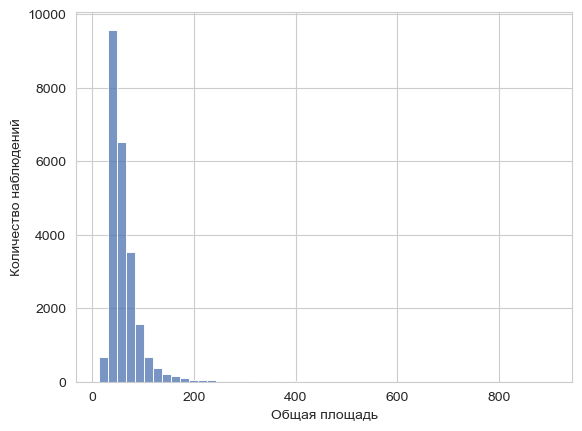

count   23650.000
mean       60.329
std        35.662
min        12.000
25%        40.000
50%        52.000
75%        69.700
max       900.000
Name: total_area, dtype: float64

In [29]:
sns.histplot(data=df, x='total_area', bins=50)
plt.xlabel('Общая площадь')
plt.ylabel('Количество наблюдений')
plt.show()

df['total_area'].describe()

**Промежуточный вывод:** Количество записей - 23650. Распределение немного скошено в сторону больших площадей. Медианное значение составляет 52 $м^2$. Имеется аномальный выброс в 900 $м^2$. Стандартное отклонение - 32,66, что может быть обусловлено этим выбросом.

**Изучим параметр "Жилая площадь"**

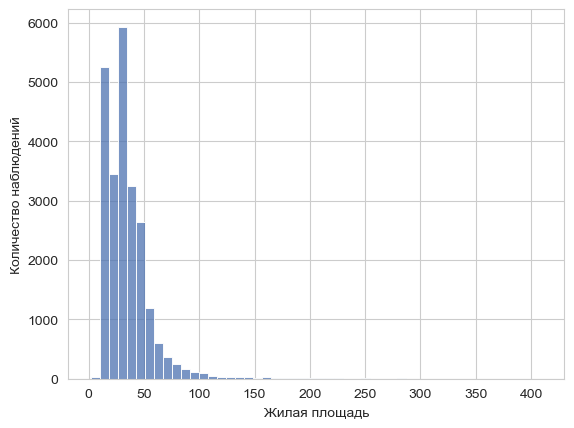

count   23650.000
mean       34.670
std        22.315
min         2.000
25%        19.000
50%        30.000
75%        42.200
max       409.700
Name: living_area, dtype: float64

In [30]:
sns.histplot(data=df, x='living_area', bins=50)
plt.xlabel('Жилая площадь')
plt.ylabel('Количество наблюдений')
plt.show()

df['living_area'].describe()

**Промежуточный вывод:** Количество записей - 23650. Распределение немного скошено в сторону меньших площадей. Медианное значение составляет 30 $м^2$. Имеются аномальные выбросы: минимальные - 2 $м^2$, максимальные - 409,7 $м^2$. Стандартное отклонение - 22,32, что может быть обусловлено выбросами.

**Изучим параметр "Площадь кухни"**

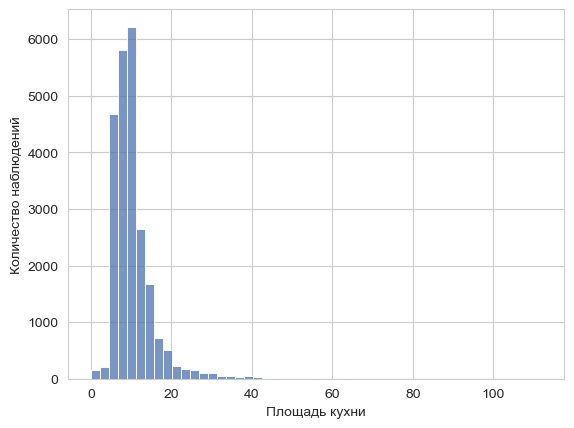

count   23650.000
mean       10.351
std         5.751
min         0.000
25%         7.000
50%         9.000
75%        11.920
max       112.000
Name: kitchen_area, dtype: float64

In [31]:
sns.histplot(data=df, x='kitchen_area', bins=50)
plt.xlabel('Площадь кухни')
plt.ylabel('Количество наблюдений')
plt.show()

df['kitchen_area'].describe()

**Промежуточный вывод:** Количество записей - 23650. Распределение немного скошено в сторону больших площадей. Медианное значение составляет 9 $м^2$. Имеется аномальный выброс в 112 $м^2$. Стандартное отклонение - 5,75, что может быть обусловлено этим выбросом. В данных присутствуют нулевые значения. Это значения квартир-студий

**Изучим параметр "Количество комнат"**

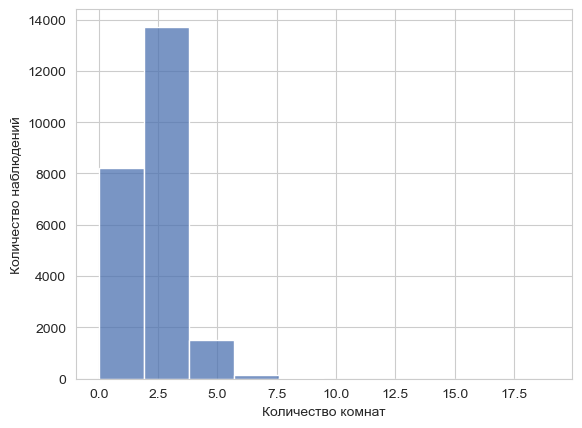

count   23650.000
mean        2.070
std         1.079
min         0.000
25%         1.000
50%         2.000
75%         3.000
max        19.000
Name: rooms, dtype: float64

In [32]:
sns.histplot(data=df, x='rooms', bins=10)
plt.xlabel('Количество комнат')
plt.ylabel('Количество наблюдений')
plt.show()

df['rooms'].describe()

**Промежуточный вывод:** Количество записей - 23650. Медианное значение составляет 2 $м^2$. Имеются аномальные выбросы: минимальный - 0 комнат, максимальный - 19 комнат. Стандартное отклонение - 1,08.

**Изучим параметр "Высота потолков"**

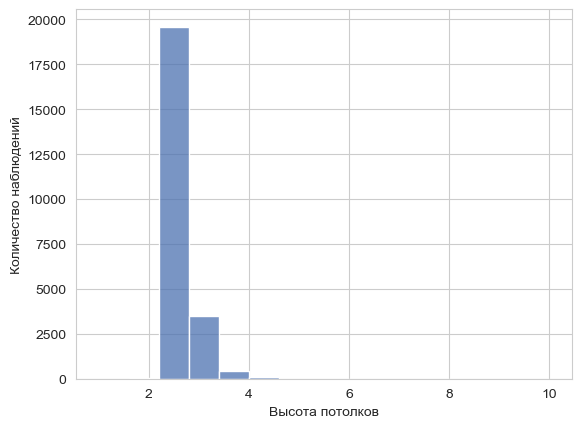

count   23650.000
mean        2.698
std         0.238
min         1.000
25%         2.600
50%         2.650
75%         2.700
max        10.000
Name: ceiling_height, dtype: float64

In [33]:
sns.histplot(data=df, x='ceiling_height', bins=15)
plt.xlabel('Высота потолков')
plt.ylabel('Количество наблюдений')
plt.show()

df['ceiling_height'].describe()

**Промежуточный вывод:** Количество записей - 23650. Медианное значение составляет 2,65 м. Имеются аномальные выбросы: минимальный - 1 м, максимальный - 10 м. Стандартное отклонение - 0,24, что означает слабое влияние выбросов на распределение

**Изучим параметр "Этаж"**

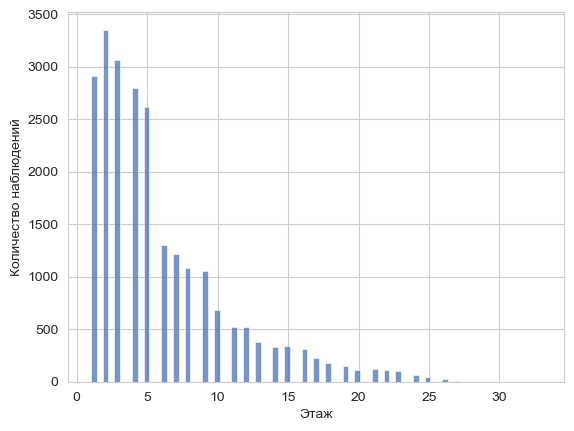

count   23650.000
mean        5.893
std         4.883
min         1.000
25%         2.000
50%         4.000
75%         8.000
max        33.000
Name: floor, dtype: float64

In [34]:
sns.histplot(data=df, x='floor')
plt.xlabel('Этаж')
plt.ylabel('Количество наблюдений')
plt.show()

df['floor'].describe()

**Промежуточный вывод:** Количество записей - 23650. Медианное значение составляет 4. Максимальное значение - 33. Стандартное отклонение - 4,88

**Изучим параметр "Тип этажа"**

Другой       17326
Последний     3440
Первый        2884
Name: type_floor, dtype: int64

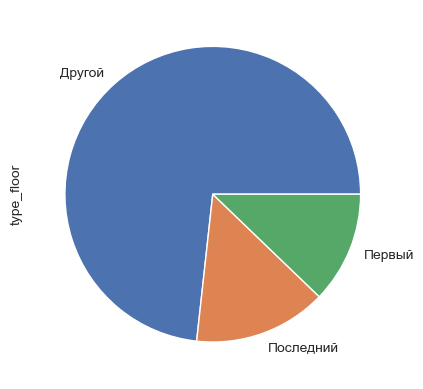

In [35]:
df['type_floor'].value_counts().plot.pie(grid=True)
df['type_floor'].value_counts()

**Промежуточный вывод:** Количество записей - 23650. Значительное часть объявлений имеет тип "Другой", то есть квартира располагается не на первом и не на последнем этажах

**Изучим параметр "Всего этажей"**

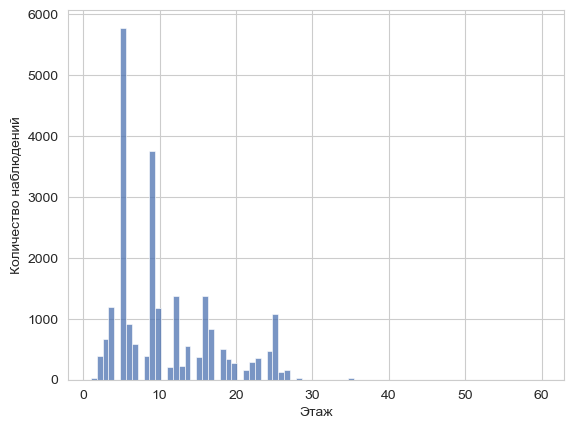

count   23650.000
mean       10.674
std         6.593
min         1.000
25%         5.000
50%         9.000
75%        16.000
max        60.000
Name: floors_total, dtype: float64

In [36]:
sns.histplot(data=df, x='floors_total')
plt.xlabel('Этаж')
plt.ylabel('Количество наблюдений')
plt.show()

df['floors_total'].describe()

**Промежуточный вывод:** Количество записей - 23650. Медианное значение составляет 9 этажей. Минимальное значение - 1 этаж, максимальное - 60 этажей. Стандартное отклонение - 6,59

**Изучим параметр "Расстояние до центра города"**

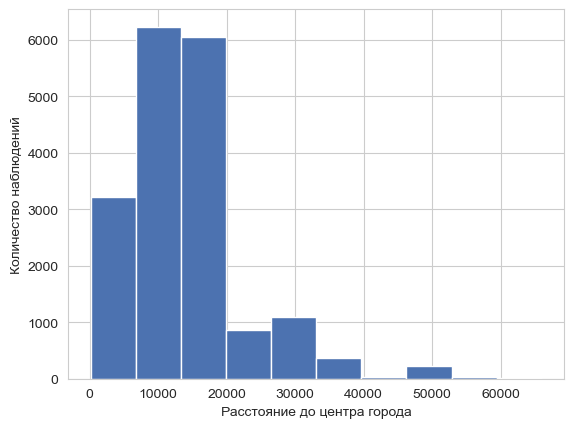

count   18139.000
mean    14197.861
std      8606.830
min       181.000
25%      9241.000
50%     13105.000
75%     16293.000
max     65968.000
Name: cityCenters_nearest, dtype: float64

In [37]:
df.hist('cityCenters_nearest', grid=True)
plt.title('')
plt.xlabel('Расстояние до центра города')
plt.ylabel('Количество наблюдений')
plt.show()

df['cityCenters_nearest'].describe()

**Промежуточный вывод:** Количество записей - 18139. Медианное значение составляет 13105 м. Минимальное значение - 181 м, максимальное - 65968 м. Стандартное отклонение - 8606,83. В данных присутствуют множественные пропуски. Их доля составляет 23,3%. Имеется резкое снижение количества результатов после значения 19500 м, что, примерно, соответствует границе города Санкт-Петербурга. А значит, появление в данных пустых значений может объясняться тем, что пользователи не указывали этот параметр при подаче объявлений

**Изучим параметр "Расстояние до аэропорта"**

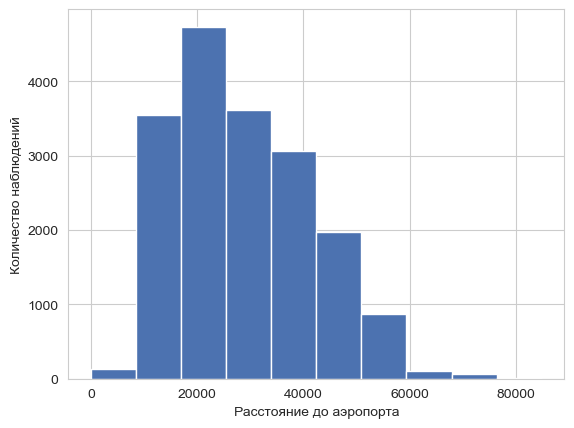

count   18116.000
mean    28803.226
std     12637.314
min         0.000
25%     18575.750
50%     26756.500
75%     37294.000
max     84869.000
Name: airports_nearest, dtype: float64

In [38]:
df.hist('airports_nearest', grid=True)
plt.title('')
plt.xlabel('Расстояние до аэропорта')
plt.ylabel('Количество наблюдений')
plt.show()

df['airports_nearest'].describe()

**Промежуточный вывод:** Количество записей - 18116. Медианное значение составляет 26756,5 м. Минимальное значение - 0 м, максимальное - 84869 м. Стандартное отклонение - 12637,31. В данных присутствуют множественные пропуски. Их доля составляет 23,4%.

**Изучим параметр "Расстояние до ближайшего парка"**

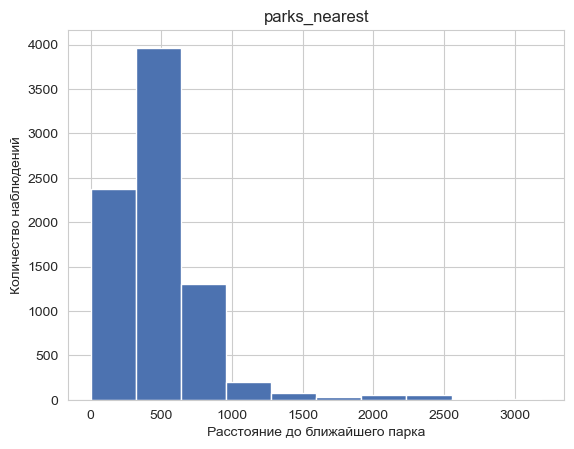

count   8064.000
mean     490.831
std      342.554
min        1.000
25%      288.000
50%      454.500
75%      612.000
max     3190.000
Name: parks_nearest, dtype: float64

In [39]:
df.hist('parks_nearest', grid=True)
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество наблюдений')
plt.show()

df['parks_nearest'].describe()

**Промежуточный вывод:** Количество записей - 8064. Медианное значение составляет 454,5 м. Минимальное значение - 1 м, максимальное - 3190 м. Стандартное отклонение - 342,55. В данных присутствуют множественные пропуски. Их доля составляет 65,9%.

**Изучим параметр "Дата подачи объявления"**

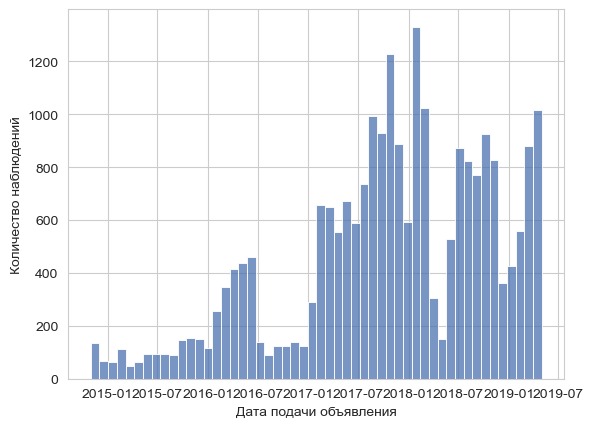

In [40]:
sns.histplot(data=df, x='day_month_exposition')
plt.xlabel('Дата подачи объявления')
plt.ylabel('Количество наблюдений')
plt.show()

**Промежуточный вывод:** Гистограмма столбца `day_month_exposition` имеет восходящий тренд, что означает стабильное увеличение количества размещаемых объявлений с течением времени.

**Изучим, как быстро продавались квартиры**

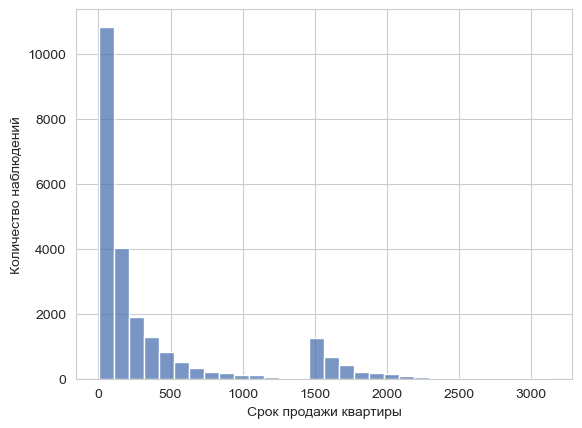

В среднем, квартиры продавались 389 дней
Медианное значение длительности продажи: 124 дней


In [41]:
sns.histplot(data=df, x='days_exposition', bins=30)
plt.xlabel('Срок продажи квартиры')
plt.ylabel('Количество наблюдений')
plt.show()

print('В среднем, квартиры продавались', round(df['days_exposition'].mean()), 'дней')
print('Медианное значение длительности продажи:', round(df['days_exposition'].median()), 'дней')

**Промежуточный вывод:** Среднее арифметическое длительности продажи квартир почти в 3 раза больше медианного значения. Связано это с тем, что есть квартиры, продающиеся значительно дольше остальных. Медианное значение сглаживает данное явление. Продажи, реализованные в промежутке 0 - 5 дней, то есть, практически сразу после подачи объявления. Необычно долгими считаем объекты, продающиеся более 3 лет (это второй пик на нашем распределении)

**Проанализируем, какие факторы больше всего влияют на полную стоимость объекта**

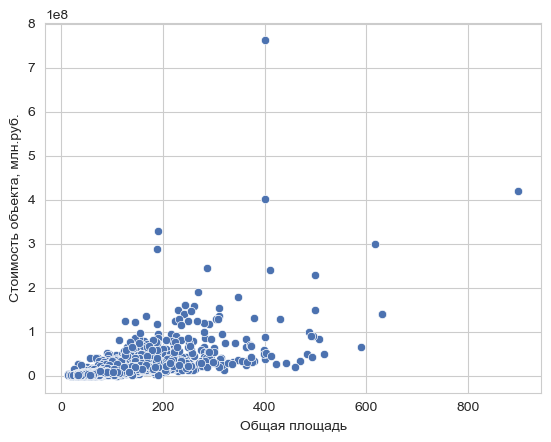

In [42]:
sns.scatterplot(data=df, x='total_area', y='last_price')
plt.xlabel('Общая площадь')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

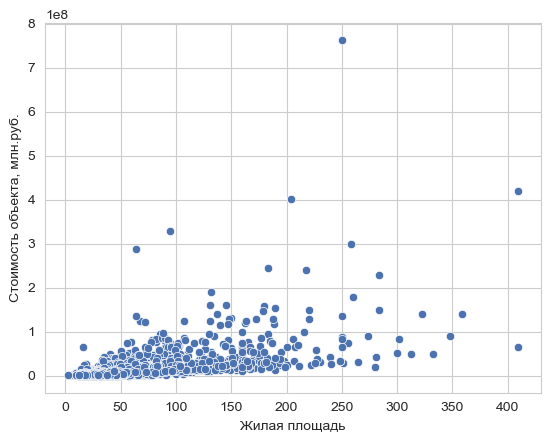

In [43]:
sns.scatterplot(data=df, x='living_area', y='last_price')
plt.xlabel('Жилая площадь')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

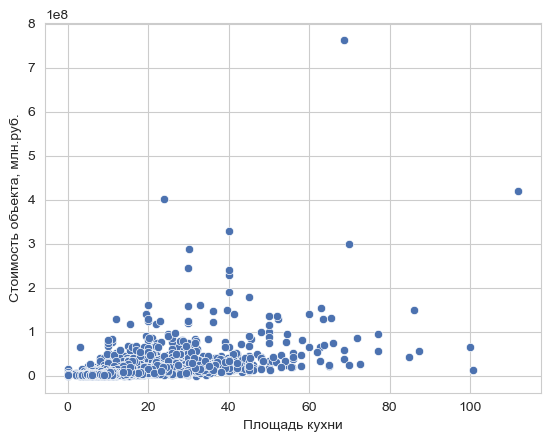

In [44]:
sns.scatterplot(data=df, x='kitchen_area', y='last_price')
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

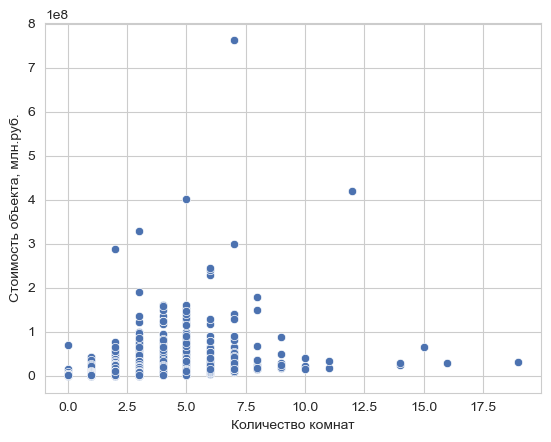

In [45]:
sns.scatterplot(data=df, x='rooms', y='last_price')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

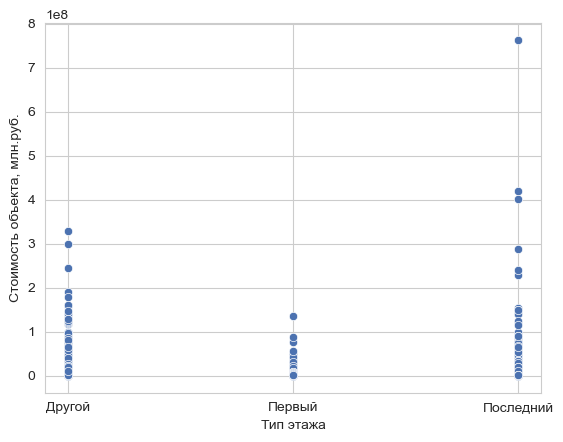

In [46]:
sns.scatterplot(data=df, x='type_floor', y='last_price')
plt.xlabel('Тип этажа')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


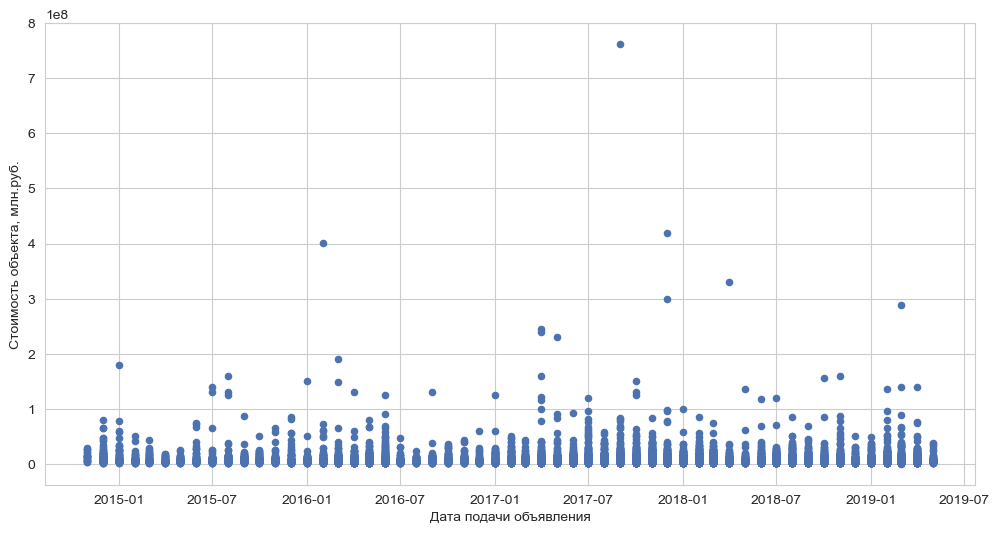

In [47]:
df.plot.scatter(x='day_month_exposition', y='last_price', figsize=(12, 6))
plt.xlabel('Дата подачи объявления')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

**Промежуточный вывод:** На полную стоимость квартир сильно влияют геометрические размеры объекта, такие как полная, жилая площади и площадь кухни. Немного слабее имеется взаимосвязь с количеством комнат - прослеживается заметное линейное увеличение стоимости квартир с количеством комнат от 1 до 7. Влияние времени на стоимость квартир практически отсутствует

**Посчитаем среднюю цену одного $м^2$**

In [48]:
# Сгруппируем данные относительно населенных пунктов
locality_max_values_top10 = df['locality_name'].value_counts().head(10).index

# Вычислим среднюю стоимость м2 в 10 населенных пунктах с наибольшим числом объявлений
(
    df.query('locality_name in @locality_max_values_top10')
    .pivot_table(index='locality_name', values='price_area', aggfunc='median')
    .sort_values(by='price_area', ascending=False)
)

,price_area
locality_name,
Санкт-Петербург,104761.905
Пушкин,100000.000
пос. Кудрово,91860.465
пос. Парголово,91642.857
пос. Мурино,85878.462
пос. Шушары,76876.173
Колпино,74723.748
Гатчина,67796.610
Всеволожск,65789.474


Самая дорогая средняя стоимость 1 $м^2$ в Санкт-Петербурге - 104761,9 руб. Самая дешевая - в Выборге, 58158,32 руб.

In [49]:
pivot_table_area = df.pivot_table(index='locality_name',
                                  values='price_area',
                                  aggfunc='median')
pivot_table_area.idxmax()

price_area    Санкт-Петербург
dtype: object

**Вычислим среднюю цену квартир в каждом километре от центра Санкт-Петербурга**

                         last_price
cityCenters_nearest_km             
0                      23442315.442
1                      18850851.663
2                      16163313.616
3                      13436830.553
4                      13632024.645
5                      15306121.120
6                      14389106.185
7                      12797673.740
8                       8445271.997
9                       6426054.857
10                      6376091.669
11                      5977038.979
12                      5972819.554
13                      6022926.607
14                      5769469.042
15                      5545776.114
16                      5527927.703
17                      4865574.004
18                      5334928.793
19                      4678755.671
20                      6365864.202
21                      5183239.246
22                      5425513.324
23                      4126866.667
24                      3862235.000
25                      4014

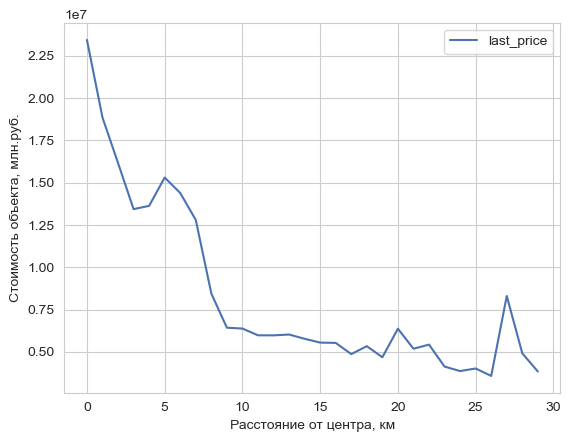

In [50]:
cityCenter_last_price = (
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km',
                 values='last_price',
                 aggfunc='mean'))
print(cityCenter_last_price)

cityCenter_last_price.plot()
plt.xlabel('Расстояние от центра, км')
plt.ylabel('Стоимость объекта, млн.руб.')
plt.show()

**Как и следовало ожидать, чем ближе объект расположен к центру города, тем он дороже. Причем, 60% своей стоимости объект теряет за первые 8 км. Скачок в 27 км от центра Санкт-Петербурга может быть обусловлен нахождению нескольких исторически значимых мест - Петергоф, Царское село. Жилье в таких населенном пункте может стоить дорого**

### Общий вывод

В данном исследовании мы проанализировали данные сервиса Яндекс.Недвижимость и установили взаимосвязь параметров объекта на рыночную стоимость объектов недвижимости. В дальнейшем это позволит построить автоматизированную систему, отслеживающую аномалии и мошенническую деятельность.

1. На первом этапе работы мы произвели чтение данных из предоставленного файла и оценили качество полученных данных


2. На втором этапе определим количество пропусков в данных, вычислили долю таких значений для выбора метода работы с пропусками.
    - В данных о количестве балконов, заменили пропущенные значения нулями, полагая, что пользователи, не указывали данные о количестве балконов, если их нет;
    - В данных об апартаментах - значениями False, также полагая, что пользователи просто не указывали этот параметр при подаче объявлений, если жилье не считается апартаментами;
    - Пустые данные о жилой площади и площади кухни вычислили, по медианным долям от общей площади объекта;
    - Также произвели проверку условия, что площадь кухни должна быть меньше жилой. Все значения, не проходящие по условию поменяли местами;
    - Учли данные по столбцу Студия. Площади кухни по строкам с такими данными заменили на нули, так как, в таких объектах, она входит в жилую площадь;
    - Заменили аномальные значения высоты потолков, умножив данные, выше 8 м на 0,01, а пропущенные данные заменили медианными;
    - В данных о названии населенного пункта нашли и исправили все неявные дубликаты;
    - Также, произвели замену типов данных для удобства вычислений и восприятия информации.


3. Для дальнейших вычислений нам потребовались дополнительная информация, на основе оригинальных данных. Так, мы добавили следующие столбцы:     
    - цена одного квадратного метра;
    - день недели публикации объявления;
    - месяц публикации объявления;
    - год публикации объявления;
    - тип этажа квартиры (значения — «первый», «последний», «другой»);
    - расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).


4. На заключительном этапе мы исследовали на наличие закономерностей наш датафрейм и получили следующие выводы:
    - Медианное значение срока продажи квартиры составляет 124 дня.
    - На стоимость объекта влияют показатели площадей кухни, жилой и полной.
    - Также на стоимости сказывается близость расположения парков и водоемов, но уже слабее.
    - В зависимости от расстояния от центра Санкт-Петербурга, особенно в первые 8 км, цена падает на 60%, дальше спад уже не так ярко выражен.
    - Попутно отслеживается восходящий тренд количества объявлений год от года, что может означать увеличение популярности сервиса объявлений.